# PACE data simple manipulation

In [4]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [5]:
auth = earthaccess.login(persist=True)

In [6]:
tspan = ("2024-07-01", "2024-07-31")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_POC_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

In [7]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    poc      (lat, lon) float32 26MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.POC.V2_0.poc...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/POC/2.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         745741
    data_minimum:                      18.199707
    data_maximum:                      1989.1997

In [10]:
poc = np.array(dataset["poc"])

In [11]:
print(poc.shape)

(1800, 3600)


## 1. Statistical Operations

In [12]:
# Mean
mean_value = np.nanmean(poc)
print("Mean value:", mean_value)

Mean value: 79.23537


In [13]:
# Median
median_value = np.nanmedian(poc)
print("Median value:", median_value)

Median value: 49.600098


In [14]:
# Standard deviation
std_value = np.nanstd(poc)
print("Standard deviation:", std_value)

Standard deviation: 105.90423


## 5. Boolean Indexing and Masking

In [15]:
# Create a boolean mask
mask = poc > 100

In [16]:
filtered_poc = poc[mask]
print("Filtered poc (concentration > 100):", filtered_poc)

Filtered poc (concentration > 100): [184.7998 184.7998 184.7998 ... 325.6001 289.1997 262.1997]


## 5. Regriding

In [17]:
poc_10lat = np.reshape(poc, (180, 10, 3600))

In [18]:
poc_latregrid = np.nanmean(poc_10lat, axis=1)

/tmp/ipykernel_147/4091360230.py:1: RuntimeWarning: Mean of empty slice
  poc_latregrid = np.nanmean(poc_10lat, axis=1)


In [19]:
poc_latregrid_10lon = np.reshape(poc_latregrid, (180, 360, 10))

In [20]:
poc_latregrid_lonregrid = np.nanmean(poc_latregrid_10lon, axis=2)

/tmp/ipykernel_147/1374962890.py:1: RuntimeWarning: Mean of empty slice
  poc_latregrid_lonregrid = np.nanmean(poc_latregrid_10lon, axis=2)


In [21]:
print(poc_latregrid_lonregrid.shape)

(180, 360)


## 9. Plotting Array Data

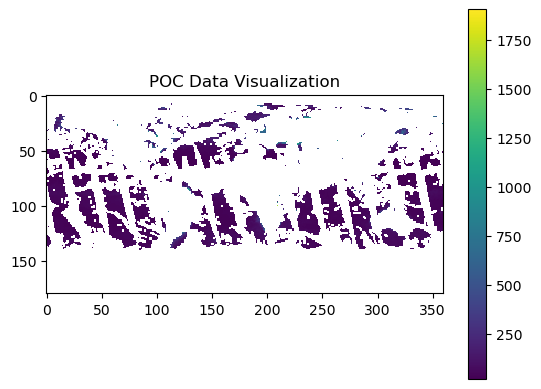

In [22]:
plt.imshow(poc_latregrid_lonregrid, cmap='viridis')
plt.colorbar()
plt.title("POC Data Visualization")
plt.show()

In [34]:
dataset = xr.open_dataset(paths[1])
dataset

<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    poc      (lat, lon) float32 26MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240702.L3m.DAY.POC.V2_0.poc...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/POC/2.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         684721
    data_minimum:                      17.799805
    data_maximum:                      1961.0

In [23]:
pocs=[]

for i in range(31):
    dataset = xr.open_dataset(paths[i])
    poc_reshaped = np.array(dataset["poc"]).reshape((180,10,360,10))
    poc_10lat = np.nanmean(poc_reshaped, axis=1)
    poc_10lat_10lon = np.nanmean(poc_10lat, axis=-1)
    pocs.append(poc_10lat_10lon)

poc_7_daily = np.stack(pocs) 

print(poc_7_daily.shape)

/tmp/ipykernel_147/2594940156.py:6: RuntimeWarning: Mean of empty slice
  poc_10lat = np.nanmean(poc_reshaped, axis=1)
/tmp/ipykernel_147/2594940156.py:7: RuntimeWarning: Mean of empty slice
  poc_10lat_10lon = np.nanmean(poc_10lat, axis=-1)


(31, 180, 360)


In [24]:
poc_7 = np.nanmean(poc_7_daily, axis=0)

/tmp/ipykernel_147/3791947967.py:1: RuntimeWarning: Mean of empty slice
  poc_7 = np.nanmean(poc_7_daily, axis=0)


In [25]:
poc_7_log10 = np.log10(poc_7)

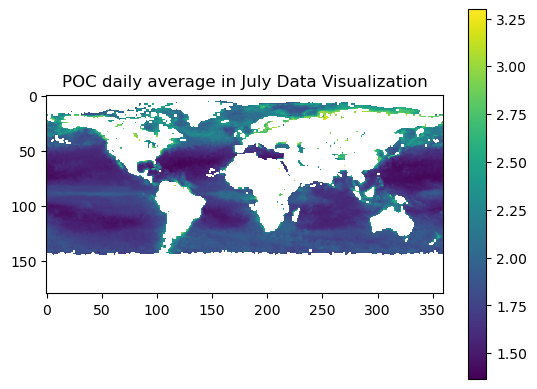

In [26]:
plt.imshow(poc_7_log10, cmap='viridis')
plt.colorbar()
plt.title("POC daily average in July Data Visualization")
plt.show()